## 0. Import Libaries

In [1]:
import numpy as np
import os
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import datetime
from functools import partial
from glob import glob
import math
import multiprocessing
from pathlib import Path
import random
from tqdm.auto import tqdm
import skimage as ski


import torch
import torchvision
from torch.amp import autocast # allows for differentr datatypes (torch.32/ torch.16)
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil


# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN, maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, MaskRCNN_ResNet50_FPN_Weights

from Mask_RCNN_load_data import load_images_from_folder, generate_index_list, load_masks_from_folder
from Mask_RCNN_manage_targets import mask_to_2dim, mask_to_2dim_no_cv2, masks_2_dim_to_booleans, mask_to_box, cull_if_no_bulding
from Mask_RCNN_manage_dataset import test_train_split, CustData, indexes_to_cull
from Mask_RCNN_model import model_summarize, train

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# set device
device = "cuda"
dtype = torch.float32
torch.cuda.empty_cache()

## 1. Load data

In [3]:
# set up projects's directory
# project's name
project_name = f"pytorch-buildings-maskrcnn"

# path for project's folder
project_dir = Path(f"/{project_name}/")

# create the project directory
project_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# maska and images directories

images_dir = "C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Images/Destroyed"  
image_filenames = sorted(os.listdir(images_dir))

mask_dir = "C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Masks/Destroyed"  
mask_filenames = sorted(os.listdir(mask_dir))

In [5]:
# load imagesm transform to torch tensors and normalise
image_tensors = load_images_from_folder(images_dir)

In [6]:
idx = 0

#img_tensor = image_tensors[idx]
#plt.imshow(img_tensor.permute(1, 2, 0))
#plt.show()

In [7]:
# load masks

mask_arrays = load_masks_from_folder(mask_dir)

## 2. Transform masks

In [8]:
# make a 2dim torch tensor in form of 0 for background, 1 for undamaged, 2 for damaged
masks_transformed = mask_to_2dim_no_cv2(mask_arrays)


In [9]:
mask = mask_arrays[idx]
#plt.imshow(mask)
#plt.show()

In [10]:
# cull images and masks with no buildings
masks_culled, image_culled = cull_if_no_bulding(masks_transformed, image_tensors)

masks_transformed, image_tensors = masks_culled.copy(), image_culled.copy()
len(masks_transformed)

114

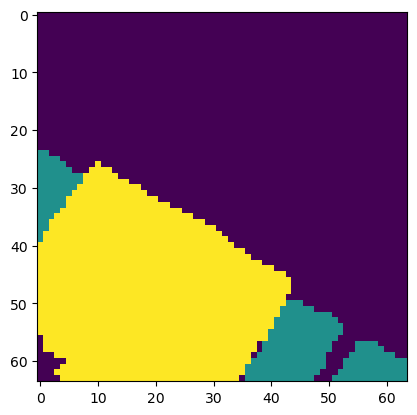

In [11]:
mask_t = masks_transformed[0]
plt.imshow(mask_t)
plt.show()


In [12]:
# takes a list of 2dim torch tensor ans transformes into list of boolean arrays for each instance
masks_binary = masks_2_dim_to_booleans(masks_transformed)


In [13]:
# make image ids(torch tensors)
image_ids = generate_index_list(image_tensors)

In [14]:
# display image with masks

image = image_tensors[idx]
mask = masks_binary[idx]
draw_mask = draw_segmentation_masks( 
    image=(image*255).to(dtype=torch.uint8), 
    masks=mask, 
    alpha=0.3,
)

#plt.imshow(draw_mask.permute(1, 2, 0))
#plt.show()

## 3. Create bounding boxes with labels

In [15]:
#  tuple of bounding boxes, tuple of boxes labels
labeled_boxes = mask_to_box(masks_transformed)
boxes, labels = labeled_boxes
print(boxes[idx], labels[idx])

tensor([[ 0., 24.,  7., 39.],
        [36., 50., 52., 63.],
        [51., 57., 63., 63.],
        [ 0., 26., 43., 63.]]) tensor([1, 1, 1, 2])


## 4. Concatinate data

In [16]:
# finds mismathed number of masks, boxes or labels for each index
indexes_to_cull = indexes_to_cull(boxes, masks_binary, labels)

In [17]:
# delete the indexes from indexes to cull
image_tensors_ = [item for i, item in enumerate(image_tensors) if i not in indexes_to_cull]
masks_binary_ = [item for i, item in enumerate(masks_binary) if i not in indexes_to_cull]
boxes_ = [item for i, item in enumerate(boxes) if i not in indexes_to_cull]
labels_ = [item for i, item in enumerate(labels) if i not in indexes_to_cull]

# make image ids
image_ids_ = generate_index_list(image_tensors_)


In [18]:
# test/ train split
train_images, test_images = test_train_split(image_tensors_)
train_masks, test_masks = test_train_split(masks_binary_)
train_boxes, test_boxes = test_train_split(boxes_)
train_labels, test_labels = test_train_split(labels_)
train_ids, test_ids = test_train_split(image_ids_)

In [19]:
# make a custom dataset
train_dataset = CustData(train_images, train_masks, train_boxes, train_labels, train_ids)
test_dataset = CustData(test_images, test_masks, test_boxes, test_labels, test_ids)
len(train_dataset)

55

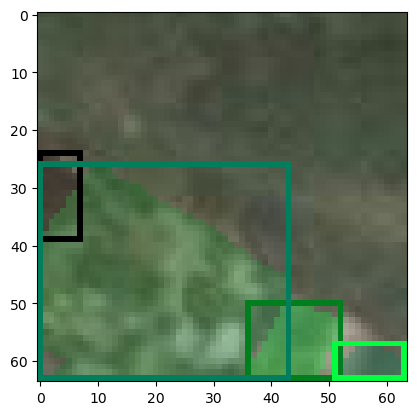

In [20]:
dataset_sample = train_dataset[idx]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3,
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'],
)

tensor_to_pil(annotated_tensor)
plt.imshow(annotated_tensor.permute(1, 2, 0))
plt.show()

## 5. Make Dataloaders

In [21]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data ! multiprocessing.cpu_count()//2 !
num_workers = 0

# collatr function specifies the way data sticks together in a batch
def collate_fn(batch):
    return tuple(zip(*batch))

def custom_collate(data):
  return data

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'collate_fn': custom_collate,
    'pin_memory': True,
    'pin_memory_device': device
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
test_dataloader = DataLoader(test_dataset, **data_loader_params)


pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(test_dataloader)}
).to_frame().style.hide(axis='columns')


#next(iter(train_dataloader))

Number of batches in train DataLoader:,14
Number of batches in validation DataLoader:,4


## 6. Loading the Mask R-CNN Model

In [22]:
classes = 3

# Initialize a Mask R-CNN model with pretrained weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn()

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=classes)

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=classes)

In [23]:
# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn'

In [24]:
model_summarize(model, device)

C:\Users\kubaw\miniforge3\envs\pytorch-env\lib\site-packages\torchtnt\utils\module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,43.9 M,43.7 M,176 M,185 G


## 7. Fine-tuning the model

In [25]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

\pytorch-buildings-maskrcnn\2023-11-09_12-03-16\maskrcnn_resnet50_fpn.pth


In [26]:
# Number of training epochs
epochs = 10

# Learning rate for the model
lr = 5e-4

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

## 8. Train!

In [27]:
model_results = train(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                epochs = epochs,
                bs = bs,
                device = device,
                optimizer=optimizer)

{'loss_classifier': tensor(1.1233, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0367, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.2417, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>)}
epoch: 0    training loss 25.53497862815857    validation loss: 5.5090651512146
epoch: 1    training loss 17.457631289958954    validation loss: 5.0453274846076965
epoch: 2    training loss 15.80670714378357    validation loss: 6.079392194747925


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 4.00 GiB total capacity; 2.87 GiB already allocated; 0 bytes free; 3.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
FILE = "model.pth"
torch.save(model, f"C:/Users/kubaw/Desktop/DELFT/CORE/{FILE}")


In [27]:
training_losses, validation_losses = model_results

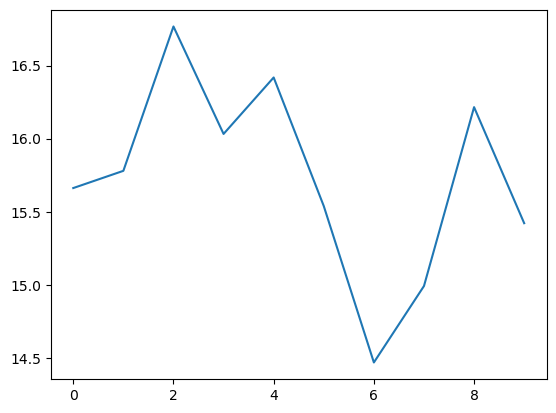

In [28]:
plt.plot(training_losses)

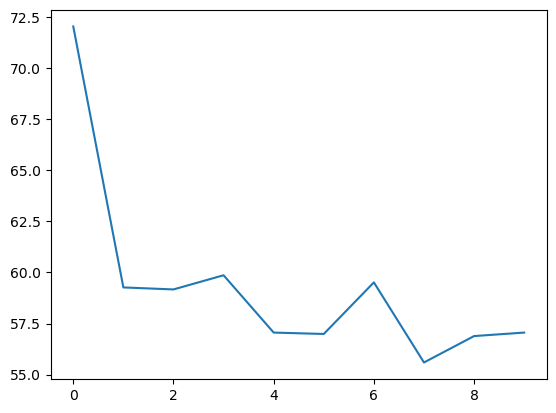

In [29]:
plt.plot(validation_losses)

In [36]:
# test the predictions on a random image 

images_dir = "C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Images/Destroyed"  
image_filenames = sorted(os.listdir(images_dir))

def load_images_from_folder(images_dir):
    images = []
    for filename in os.listdir(images_dir):
        if filename.endswith('.jpeg'):
            img = Image.open(os.path.join(images_dir, filename))
            images.append(img)
    return images

images_test = load_images_from_folder(images_dir)

In [37]:
# model into inference mode
model.eval()
model.to(device)
transform = T.Compose([T.ToTensor()])

im_test = images_test[20]
input_tensor = transform(im_test).to(device)  # Move the input tensor to the same device as the model

with torch.no_grad():
    pred = model(input_tensor.unsqueeze(0))  
    

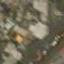

In [38]:
im_test

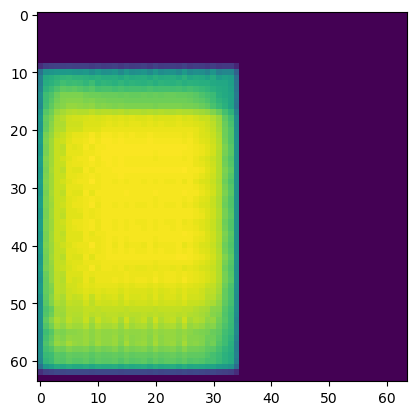

In [39]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())